<a href="https://colab.research.google.com/github/AnaliaLeyez/AnaliaLeyez/blob/main/eda_black_friday_29_04_25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Consigna:

https://www.kaggle.com/datasets/prepinstaprime/black-friday-sales-data


Una empresa minorista llamada "ABC Private Limited" quiere entender el comportamiento de compra de sus clientes (específicamente, el monto de compra) en relación con varios productos de diferentes categorías. Han compartido resúmenes de compras de distintos clientes correspondientes a productos seleccionados de alto volumen del mes pasado.

El conjunto de datos también contiene información demográfica de los clientes (edad, género, estado civil, tipo de ciudad, tiempo de residencia en la ciudad actual), detalles de productos (ID de producto y categoría del producto), y el monto total de compra del mes pasado.

Ahora, quieren construir un modelo que permita predecir el monto de compra de los clientes para diferentes productos, lo cual les ayudará a crear ofertas personalizadas para los clientes según cada producto.


# Paso 0: Imports y lectura

Este fragmento de código desactiva temporalmente las advertencias (warnings) que Python o las bibliotecas pueden generar durante la ejecución del notebook. Las advertencias no son errores: simplemente indican que algo podría no estar funcionando de la forma esperada o que una función podría quedar obsoleta en el futuro.  
⚠️ Importante: Esta práctica es útil para notebooks de exploración o presentación, pero no se recomienda ignorar advertencias en entornos de producción, ya que pueden ocultar problemas que merecen atención.



In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Importamos librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
import kagglehub
import os

# Seteo Variable de entorno KAGGLEHUB_CACHE, donde se descargara el archivo
os.environ["KAGGLEHUB_CACHE"] = "/content"

# Download latest version
path = kagglehub.dataset_download("prepinstaprime/black-friday-sales-data")

print("Path to dataset files:", path)
# lo muevo al directorio de trabajo
!cp -r {path} .
## muevo el archivo descargado y al mismo tiempo renombro el mismo
!cp /content/black-friday-sales-data/train.csv /content/black-friday-sales.csv
print("archivo /content/black-friday-sales.csv disponible")

In [ ]:
# Levantamos el dataset principal
df = pd.read_csv('/content/black-friday-sales.csv')

# Paso 1: Conociendo los datos

In [ ]:
df

In [ ]:
# Observamos las primeras filas
df.head(5)

In [ ]:
# Observamos las ultimas
df.tail(5)

In [ ]:
# Analizamos los tipos de datos
df.dtypes

In [ ]:
# Determinamos cuantas filas y columnas posee el dataset
df.shape

In [ ]:
df.info()

In [ ]:
# Verificamos las categorías únicas dentro de cada columna
df.nunique()

In [ ]:
# Verificamos la cantidad total de nulos dentro de cada columna
df.isnull().sum()

Combinamos con datasets de descripciones

In [ ]:
# Descripcion de ciudades
!cat /content/city_category.csv

In [ ]:
# Descripciones de ciudades
df_city_cat = pd.read_csv('/content/city_category.csv')

Esta línea une los DataFrames df y df_city_cat en base a una columna en común 'City_Category', siguiendo el enfoque de una combinación tipo LEFT JOIN (como en SQL).  
Si un valor en City_Category (del df) no tiene una coincidencia en City_category (de df_city_cat), entonces:

*   La fila se conserva igual en el DataFrame final (porque es un left join).
*   Pero las columnas provenientes de df_city_cat se completan con NaN (valores nulos), indicando que no se encontró coincidencia.

En nuestro caso todas tienen coincidecia por lo que no estaremos generando nuevos NaN.

In [ ]:
# Combinar con el dataset original
df = pd.merge(df, df_city_cat, left_on='City_Category', right_on='City_category', how='left')

In [ ]:
df

In [ ]:
# Renombramos la descripcion de la ciudad
df = df.rename(columns={'Description': 'Description_City_Category'})

In [ ]:
df

In [ ]:
# Ocupaciones
!head /content/occupation.csv

In [ ]:
df_occupation = pd.read_csv('/content/occupation.csv')

In [ ]:
# Combinamos con el dataset original
df = pd.merge(df, df_occupation, left_on='Occupation', right_on='Occupation_ID', how='left')

In [ ]:
# Renombramos la descripcion de la ocupación
df = df.rename(columns={'Description': 'Description_Occupation'})

In [ ]:
df

In [ ]:
duplicate_rows = df[df.duplicated()]

if duplicate_rows.empty:
    print("No existen filas duplicadas")
else:
    print("Se encontraron filas duplicadas")
    print(duplicate_rows)

# Paso 2: Preparación

En análisis de datos, especialmente durante la etapa de análisis exploratorio (EDA), necesitamos realizar tareas repetitivas sobre los datos: revisar tipos de variables, contar valores únicos, detectar valores faltantes, etc.

Por ejemplo podemos definir la función unique(df) diseñada para automatizar y resumir esa exploración básica sobre un DataFrame.

In [ ]:
def unique(df):
    data = []

    for col in df.columns:
        # Obtenemos la cantidad de valores únicos de la columna
        num_unique = df[col].nunique()

        # Agregamos los valores únicos a la lista si son como máximo 10 sino indicamos que posee mas de 10 vaores únicos.
        if num_unique <= 10:
            unique_vals = list(df[col].unique())
        else:
            unique_vals = "Más de 10 valores únicos"

        # Obtenemos el tipo de dato de la columna
        data_type = df[col].dtype

        # Contamos la cantidad de valores faltantes de la columna y calculamos el porcentaje
        num_missing = df[col].isnull().sum()
        percent_of_missing = round((num_missing / df.shape[0]) * 100, 2)

        # Armamos diccionarios con las claves y los valores que obtuvimos y los guardamos en la lista
        data.append({
            'Columna': col,
            'Tipo_Dato': data_type,
            'Q_Valores_Unicos': num_unique,
            'Valores_Unicos': unique_vals,
            'Q_Valores_Faltantes': num_missing,
            'Porcentaje_Valores_Faltantes': percent_of_missing
        })

    # Creamos un dataframe
    df_unique = pd.DataFrame(data)

    return df_unique

In [ ]:
unique(df)

# Paso 3: Análisis univariado

In [ ]:
sns.set(style="whitegrid")

# Crear figura con tamaño (15x10 pulgadas)
fig, axes = plt.subplots(2, 3, figsize=(25, 15))

# --------------------------
# Distribución por Rango de Edad
sns.countplot(x='Age', data=df, palette='pastel',
              order=["0-17", "18-25", "26-35", "36-45", "46-50", "51-55", "55+"],
              ax=axes[0, 0])
axes[0, 0].set_title('Distribución por Rango de Edad')
axes[0, 0].set_xlabel('Grupo Etario')
axes[0, 0].set_ylabel('Cantidad')

# --------------------------
# Distribución por Género
sns.countplot(x='Gender', data=df, palette='Set2', ax=axes[0, 1])
axes[0, 1].set_title('Distribución por Género')
axes[0, 1].set_xlabel('Género')
axes[0, 1].set_ylabel('Cantidad')

# --------------------------
# Distribución por Ocupación
sns.countplot(y='Description_Occupation', data=df, palette='colorblind', ax=axes[0, 2])
axes[0, 2].set_title('Distribución por Ocupación')
axes[0, 2].set_xlabel('Cantidad')
axes[0, 2].set_ylabel('Ocupación')

# --------------------------
# Distribución por Categoría de Ciudad
sns.countplot(x='Description_City_Category', data=df, palette='muted', ax=axes[1, 0])
axes[1, 0].set_title('Distribución por Tipo de Ciudad')
axes[1, 0].set_xlabel('Ciudad')
axes[1, 0].set_ylabel('Cantidad')

# --------------------------
# Distribución según Años en la Ciudad Actual
sns.countplot(x='Stay_In_Current_City_Years', data=df, palette='pastel', ax=axes[1, 1])
axes[1, 1].set_title('Antigüedad en la Ciudad Actual')
axes[1, 1].set_xlabel('Años de Residencia')
axes[1, 1].set_ylabel('Cantidad')

# --------------------------
# Distribución por Estado Civil
sns.countplot(x='Marital_Status', data=df, palette='husl', ax=axes[1, 2])
axes[1, 2].set_title('Distribución por Estado Civil')
axes[1, 2].set_xlabel('Estado Civil (0 = Soltero/a, 1 = Casado/a)')
axes[1, 2].set_ylabel('Cantidad')

# Ajustar diseño para evitar superposición
plt.tight_layout()

# Mostrar todos los gráficos
plt.show()


Insights

📊 Distribución por Género:
Los compradores varones superan en número a las mujeres, lo que indica un posible desequilibrio de género en la participación del Black Friday.

👥 Grupo Etario:
El grupo de edad 26-35 años fue el más activo durante las compras del Black Friday, siendo el segmento etario predominante.

🏙️ Categoría de Ciudad:
La Categoría de Ciudad B concentró la mayor cantidad de compradores, lo que subraya la importancia estratégica de esta ubicación en el mercado minorista del Black Friday.

🕒 Antigüedad en la Ciudad:
Las personas que llevan 1 año viviendo en su ciudad actual fueron las más activas en las compras, lo que sugiere un mayor nivel de compromiso de los recién llegados.

💍 Estado Civil:
Los solteros/as (Estado Civil = 0) fueron el grupo más numeroso de compradores, lo cual indica que son una audiencia clave durante este evento.

**Recomendaciones**

1. Campañas Dirigidas por Género:
Diseñar promociones y combos atractivos tanto para compradores hombres como mujeres.

Usar publicidad segmentada por género para mejorar la participación.

2. Ofertas Personalizadas por Grupo Etario:
Centrar los esfuerzos de marketing en el grupo de edad 26-35 años.

Crear promociones específicas y recomendaciones de productos para este segmento, el más numeroso.

3. Marketing Focalizado por Ciudad:
Priorizar campañas de marketing en la Ciudad Categoría B, con acciones específicas para esa ubicación.

Ofrecer promociones locales para incrementar las ventas.

4. Atraer a Nuevos Residentes:
Adaptar estrategias para personas con 1 año de residencia, ofreciendo descuentos exclusivos para nuevos habitantes.

Incluir paquetes de bienvenida o promociones de introducción.

5. Promociones para Solteros/as:
Crear campañas dirigidas a los intereses y necesidades de los solteros.

Promocionar productos o servicios que resuenen con personas sin pareja, dada su alta representación.

6. Recomendaciones Personalizadas:
Aplicar analítica de datos y motores de recomendación para sugerir productos basados en edad, género y otras variables demográficas.

Personalizar promociones para aumentar la conversión y la satisfacción del cliente.

7. Estrategias de Retención:
Implementar programas de fidelización y promociones posteriores al Black Friday.

Ofrecer beneficios exclusivos para fomentar compras repetidas de los grupos clave identificados.

In [ ]:
df["Product_Category_2"].fillna(0, inplace=True)

In [ ]:
df["Product_Category_3"].fillna(0, inplace=True)

In [ ]:
df['Product_Category_2'].value_counts()


In [ ]:
df['Product_Category_3'].value_counts()

In [ ]:
df = df.astype({"Product_Category_2": int, "Product_Category_3": int})

In [ ]:
df

**Analizamos el Ticket de Compra**

In [ ]:
sns.set_style('darkgrid')

# Crear subgráficos
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Análisis Univariado del Monto de Compra', fontsize=16)
plt.subplots_adjust(wspace=0.4)

# Histograma
sns.histplot(df['Purchase'], bins=30, color='skyblue', ax=axes[0])
axes[0].set_title('Histograma del Monto de Compra')
axes[0].set_xlabel('Monto de Compra')
axes[0].set_ylabel('Frecuencia')

# KDE (Estimación de Densidad)
sns.kdeplot(data=df['Purchase'], ax=axes[1], color='orange', fill=True)
axes[1].set_title('Estimación de Densidad (KDE)')
axes[1].set_xlabel('Monto de Compra')
axes[1].set_ylabel('Densidad')

# Boxplot
sns.boxplot(y='Purchase', data=df, color='salmon', ax=axes[2])

# Media (como punto azul)
media = df['Purchase'].mean()
ax.scatter(1, media, color="blue", marker="o", s=100, label="Media")

axes[2].set_title('Boxplot del Monto de Compra')
axes[2].set_ylabel('Monto de Compra')

# Mostrar gráficos
plt.show()


**Histograma**: Nos muestra la frecuencia de compras en distintos rangos. Observamos que la mayoría de los montos se concentran entre aproximadamente 5.000 y 10.000 unidades monetarias.

**KDE** (Estimación de Densidad): Este gráfico suaviza el histograma y permite visualizar la forma de la distribución. En este caso:

La curva tiene una sola moda (es unimodal).

La distribución está ligeramente sesgada a la derecha (hay algunos valores de compra muy altos que tiran la curva hacia ese lado).

No es completamente normal, pero tampoco extremadamente dispersa.

**Boxplot**: Muestra la mediana, los cuartiles y los valores atípicos (outliers). Aquí también se observa que:

Hay muchos valores extremos por encima del tercer cuartil.

La mediana está por debajo del promedio, lo que también sugiere un sesgo positivo.



In [ ]:
#Otro modo de graficar el histograma con la curva de densidad superpuesta.
plt.style.use('ggplot') # desde matplotlib podemos aplicar estilos y colores de gráfica similares a los de la libreria ggplot2 de R.

# Crear figura
plt.figure(figsize=(15, 5))

# Histograma + KDE
sns.histplot(df['Purchase'], bins=30, kde=True, color='teal')

# Títulos y etiquetas
plt.title('Distribución del Ticket de Venta', fontdict={'fontname': 'DejaVu Sans', 'fontsize': 15, 'fontweight': 'bold'})
plt.xlabel('Monto de Compra', fontdict={'fontname': 'DejaVu Sans', 'fontsize': 10})
plt.ylabel('Cantidad de Personas', fontdict={'fontname': 'DejaVu Sans', 'fontsize': 10})
plt.tick_params(labelsize=15)

# Mostrar gráfico
plt.show()

In [ ]:
# cuales serán los más vendidos :
top_10_vendidos = df['Product_ID'].value_counts().head(10)

In [ ]:
top_10_vendidos

In [ ]:
# expresamos lo mismo pero con group by :
top_10_vendidos_2 = df.groupby('Product_ID').size().sort_values(ascending=False).head(10)

In [ ]:
top_10_vendidos_2

In [ ]:
# graficamos
plt.figure(figsize=(12, 6))
sns.barplot(x=top_10_vendidos.index, y=top_10_vendidos.values, palette='viridis')
plt.xticks(rotation=90)
plt.xlabel('ID del Producto')
plt.ylabel('Cantidad Vendida')
plt.title('Top 10 Artículos Más Vendidos')
plt.tight_layout()
plt.show()

# Paso 4: Análisis multivariado

In [ ]:
# y los 10 mas vendidos en monto
# Calculamos el monto total facturado por producto , en este caso como usamos la función de agregación .sum() utilizamos necesariamente group by:
total_purchase_per_product = df.groupby('Product_ID')['Purchase'].sum().reset_index()

In [ ]:
# Obtenemos los 10 productos con mayor facturación total
top_10_monto_total = total_purchase_per_product.nlargest(10, 'Purchase')

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Product_ID', y='Purchase', data=top_10_monto_total, palette='viridis')
plt.xticks(rotation=90)
plt.xlabel('ID del Producto')
plt.ylabel('Monto Total de Venta')
plt.title('Top 10 Productos con Mayor Facturación')
plt.tight_layout()
plt.show()

In [ ]:
# Montos de compra por ocupación
plt.figure(figsize=(15, 7))
sns.barplot(x='Description_Occupation', y='Purchase', data=df, palette='Paired')

plt.title('Montos de compra por Ocupación', fontdict={'fontname': 'DejaVu Sans', 'fontsize': 15, 'fontweight': 'bold'})
plt.xlabel('Ocupación', fontdict={'fontname': 'DejaVu Sans', 'fontsize': 15})
plt.ylabel('Monto promedio de compra', fontdict={'fontname': 'DejaVu Sans', 'fontsize': 15})
plt.tick_params(labelsize=10)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# Montos de compra por edad
plt.figure(figsize=(15, 7))
sns.barplot(x='Age', y='Purchase', data=df, palette='Paired')

plt.title('Montos de compra por Edad', fontdict={'fontname': 'DejaVu Sans', 'fontsize': 15, 'fontweight': 'bold'})
plt.xlabel('Edad', fontdict={'fontname': 'DejaVu Sans', 'fontsize': 15})
plt.ylabel('Monto promedio de compra', fontdict={'fontname': 'DejaVu Sans', 'fontsize': 15})
plt.tick_params(labelsize=10)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
# Montos de compra por género
plt.figure(figsize=(15, 7))
sns.barplot(x='Gender', y='Purchase', data=df, palette='Paired')

plt.title('Montos de compra por Género', fontdict={'fontname': 'DejaVu Sans', 'fontsize': 15, 'fontweight': 'bold'})
plt.xlabel('Género', fontdict={'fontname': 'DejaVu Sans', 'fontsize': 15})
plt.ylabel('Monto promedio de compra', fontdict={'fontname': 'DejaVu Sans', 'fontsize': 15})
plt.tick_params(labelsize=10)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

Consumo por genero con Group By

In [ ]:
df[['Gender', 'Purchase']].groupby('Gender')['Purchase'].sum()\
.to_frame()\
.rename(columns={'Purchase':'Monto'})\
.reset_index()\
.sort_values(by='Monto', ascending=False)

.to_frame() convierte el Series resultante del agrupamiento en un DataFrame. Esto es necesario para poder trabajar con el DataFrame y realizar más manipulaciones, ya que groupby() seguido de una agregación como sum() devuelve un Series, que tiene solo un índice (en este caso, Gender)    
  
  
.reset_index() restablece el índice del DataFrame. Después de realizar el agrupamiento, el índice de nuestro DataFrame es el valor de Gender (es decir, los géneros 'Male', 'Female', etc.). Usando .reset_index(), movemos esa columna de vuelta al DataFrame como una columna normal, y el índice del DataFrame se restablece a valores numéricos (0, 1, 2, etc.).

In [ ]:
g = df.groupby('Gender')['Marital_Status'].value_counts().to_frame()\
.rename({'Marital_Status':'Count'}, axis=1)\
.reset_index()

Esto genera un Series con MultiIndex (índice jerárquico) con los niveles:

Gender

Marital_Status   
Y como valor, el conteo de ocurrencias.  
.to_frame() convierte la Series resultante en un DataFrame. Por defecto, la única columna se llama Marital_Status, porque esa era la columna sobre la cual aplicamos value_counts().  
Cambiamos el nombre de la columna de Marital_Status a Count, porque ahora ya no representa estados civiles sino la cantidad de registros por cada combinación.  
.reset_index() Convierte el índice múltiple (Gender, Marital_Status) en columnas normales del DataFrame, y reinicia el índice a valores numéricos (0, 1, 2...).

In [ ]:
g

# Paso 5: Correlaciones

In [ ]:
# Seleccionar las columnas numéricas para calcular la matriz de correlación
numeric_columns = df.select_dtypes(include=['int64', 'float64'])

In [ ]:
# Calcular la matriz de correlación
correlation_matrix = numeric_columns.corr()

In [ ]:
# Visualizar la matriz de correlación en un mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriz de Correlación')
plt.show()

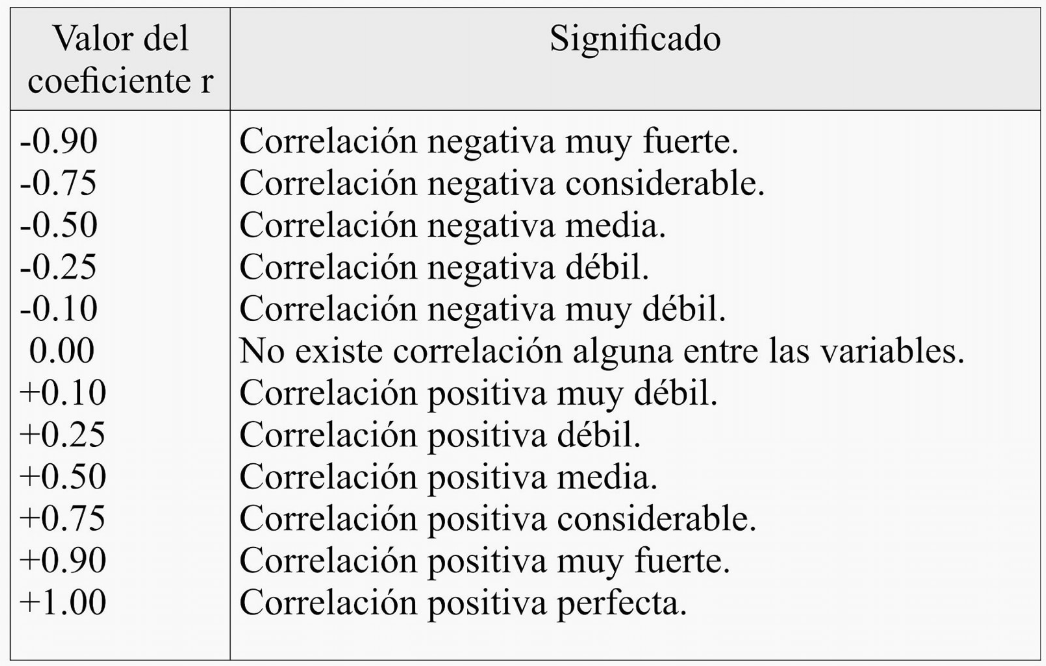

In [ ]:
# Crear un diccionario que mapea cada rango de edad a un valor numérico (por ej podríamos usar el promedio del rango)
rango_a_numero = {
    '26-35': 30,
    '36-45': 40,
    '18-25': 20,
    '46-50': 45,
    '55+': 50,
    '0-17': 15
}

In [ ]:
df['Edad_numerica'] = df['Age'].map(rango_a_numero)

In [ ]:
numeric_columns = df.select_dtypes(include=['int64', 'float64'])

# Calcular la matriz de correlación
correlation_matrix = numeric_columns.corr()

In [ ]:
# Visualizar la matriz de correlación en un mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriz de Correlación')
plt.show()

Interpretación de la matriz de correlación:

Correlaciones fuertes:

Occupation y Occupation_ID (1.00): Correlación perfecta positiva, lo que sugiere que son variables redundantes (ej: Occupation_ID es una codificación numérica de Occupation). Convendría eliminar una de ellas en análisis posteriores.

Marital Status y Edad_numérica (0.27): Correlación positiva moderada, indicando que personas de mayor edad tienden a estar casadas, aunque la relación no es muy fuerte.

Correlaciones negativas destacadas:

Product_Category_1 vs. Product_Category_3 (-0.39): Correlación negativa moderada. Sugiere que los usuarios que compran en una categoría tienden a comprar menos en la otra.

Product_Category_1 vs. Purchase (-0.34): Correlación negativa, lo que podría implicar que comprar en esta categoría está asociado con montos de compra más bajos.

Correlaciones positivas relevantes:

Product_Category_3 vs. Purchase (0.29): Correlación positiva débil, indicando que las compras en esta categoría podrían estar ligadas a montos de compra ligeramente mayores.

Variables con correlaciones cercanas a 0:

User_ID muestra correlaciones casi nulas con todas las variables, lo cual es esperable (User_ID no aporta información predictiva).

Product_Category_2 tiene correlaciones débiles con otras variables, lo que sugiere poca influencia lineal en el contexto analizado.

Observaciones adicionales:

La correlación entre Occupation_ID y Edad_numérica (0.10) es muy débil, lo que descarta una relación significativa entre la ocupación y la edad en estos datos.

Las correlaciones cercanas a 0 en la mayoría de las variables demográficas (como Marital Status) sugieren que estos factores tienen un impacto limitado en las compras o categorías de productos.